<a href="https://colab.research.google.com/github/neelakshij/Cough_Analysis/blob/main/CNN_to_log_mel_spectogram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### model log-mel-spectogram and its derivatives with CNN

training set: df_train.csv & ftr_train.npy
augmented training set for labels psuedocough(==1) and sever(==2): auf_df_train.csv & ftr_train_aug.npy  
training set with augmented values: merged_df.csv & merged_ftr.npy

validation set: df_validation.csv & ftr_validation.npy

test set: df_test.csv & ftr_test.npy

Refered links: https://github.com/vrwilm/accent-detection/blob/main/4.2_MelSpectogram%2BCNN_LANG_SET2.ipynb

In [2]:
# mount our Google Drive to our working directory through extension
import os
from google.colab import drive

MOUNTPOINT = "/content/gdrive"
DATADIR = os.path.join(MOUNTPOINT, "MyDrive")
drive.mount(MOUNTPOINT)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
# import libraries
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, AveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam,RMSprop,Nadam,Adadelta

In [5]:
# load dataframes of train, validation and test sets
# need to append drive link... "19OqxLCsvKLiBrdQeI9833GrLOpfge30f
df_train = pd.read_csv('/content/gdrive/MyDrive/omdenaLC-CoughSeverityDetection/files/df_train.csv')
df_train_augmented = pd.read_csv('/content/gdrive/MyDrive/omdenaLC-CoughSeverityDetection/files/aug_df_train.csv')
df_merged = pd.read_csv('/content/gdrive/MyDrive/omdenaLC-CoughSeverityDetection/files/merged_df.csv') # df_train + df for augmented features
df_validation = pd.read_csv('/content/gdrive/MyDrive/omdenaLC-CoughSeverityDetection/files/df_validation.csv')
df_test = pd.read_csv('/content/gdrive/MyDrive/omdenaLC-CoughSeverityDetection/files/df_test.csv')

# load respective feature matrices
feature_train = np.load("/content/gdrive/MyDrive/omdenaLC-CoughSeverityDetection/files/ftr_train.npy")
feature_train_augmented = np.load("/content/gdrive/MyDrive/omdenaLC-CoughSeverityDetection/files/ftr_train_aug.npy")
#feature_merged = np.load("/content/gdrive/MyDrive/omdenaLC-CoughSeverityDetection/files/merged_train_ftr.npy")  # feature_train + augmented features
feature_validation = np.load("/content/gdrive/MyDrive/omdenaLC-CoughSeverityDetection/files/ftr_validation.npy")
feature_test = np.load("/content/gdrive/MyDrive/omdenaLC-CoughSeverityDetection/files/ftr_test.npy")

# check dimentions
print(df_train.shape, df_train_augmented.shape, df_merged.shape, df_validation.shape, df_test.shape)
print(feature_train.shape, feature_train_augmented.shape, feature_validation.shape, feature_test.shape)

(1712, 3) (822, 3) (2534, 3) (367, 3) (368, 3)
(64, 316, 3, 1712) (64, 316, 3, 822) (64, 316, 3, 367) (64, 316, 3, 368)


In [6]:
# merged (train+augmented_train) feature set
merged_ftr = np.zeros((64,316,3,2534))
merged_ftr[:,:,:,0:1712] = feature_train
merged_ftr[:,:,:,1712:] = feature_train_augmented

In [7]:
#np.save("/content/gdrive/MyDrive/omdenaLC-CoughSeverityDetection/files/merged_train_ftr.npy",merged_ftr)

In [7]:
# need to reshape mergerd features matrix
X_merged = merged_ftr.reshape((2534,64,316,3))
X_merged.shape

(2534, 64, 316, 3)

In [8]:
# need to reshape validation and test features matrices
ftr_val = feature_validation.reshape((feature_validation.shape[-1],64,316,3))
ftr_test = feature_test.reshape((feature_test.shape[-1],64,316,3))
print(ftr_val.shape, ftr_test.shape)

(367, 64, 316, 3) (368, 64, 316, 3)


In [9]:
# To normalize X_merged: need to do seperately for log-mel-spectogram and derivatives.
# So need to normalize data per channel

# create three instances of StandardScaler as each matrix contains three different feature.
# also we need these to scale validation and test datasets.
scaler0 = StandardScaler()
scaler1 = StandardScaler()
scaler2 = StandardScaler()
scaler = [scaler0,scaler1,scaler2]
# to save normalized features
normalized_features = np.zeros((2534,64,316,3))

# looping over number of samples
for i in range(X_merged.shape[0]):
    for ch in range(3):
        ch_mat = scaler[ch].fit_transform(X_merged[i,:,:,ch])
        normalized_features[i,:,:,ch] = ch_mat

normalized_features.shape

(2534, 64, 316, 3)

In [10]:
# similarly normalize validation and test feature datasets using scalers used to fit training dataset

normalized_ftr_val = np.zeros(ftr_val.shape)
# looping over number of samples in validation set
for i in range(ftr_val.shape[0]):
    for ch in range(3):
        ch_mat = scaler[ch].fit_transform(ftr_val[i,:,:,ch])
        normalized_ftr_val[i,:,:,ch] = ch_mat

normalized_ftr_test = np.zeros(ftr_test.shape)
# looping over number of samples in test set
for i in range(ftr_test.shape[0]):
    for ch in range(3):
        ch_mat = scaler[ch].fit_transform(ftr_test[i,:,:,ch])
        normalized_ftr_test[i,:,:,ch] = ch_mat

print(normalized_ftr_val.shape, normalized_ftr_test.shape )

(367, 64, 316, 3) (368, 64, 316, 3)


In [11]:
X_train = normalized_features
y_train = df_merged['severity']

X_val = normalized_ftr_val
y_val = df_validation['severity']

X_test = normalized_ftr_test
y_test = df_test['severity']

print("trainSet: ",X_train.shape, y_train.shape)
print("validationSet: ",X_val.shape, y_val.shape)
print("testSet: ",X_test.shape, y_test.shape)

trainSet:  (2534, 64, 316, 3) (2534,)
validationSet:  (367, 64, 316, 3) (367,)
testSet:  (368, 64, 316, 3) (368,)


In [12]:
input_shape = X_train.shape[1:]
input_shape

(64, 316, 3)

In [13]:
def plot_confusion_matrix(model, X_test):
    """
    Plots confusion matrix for model prediction on test
    """

    y_pred = model.predict(X_test)

    y_pred = np.argmax(y_pred, axis=1)

    y_true = y_test

    confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8,6))
    sns.heatmap(confusion_mtx,
                #xticklabels=languages,
                #yticklabels=languages,
                annot=True, fmt='g')
    plt.xlabel('Prediction')
    plt.ylabel('Label')
    plt.show()

In [14]:
def plot_history(history):
    """
    Plots accuracy/loss for training/validation set as a function of the epochs
    """

    fig, ax = plt.subplots(figsize=(12,6), ncols=2)

    # accuracy sublpot
    ax[0].plot(history.history["accuracy"], label="train accuracy")
    ax[0].plot(history.history["val_accuracy"], label="val accuracy")
    ax[0].set_ylabel("Accuracy")
    ax[1].set_xlabel("Epoch")
    ax[0].set_ylim([0,1])
    ax[0].set_title("Accuracy")

    # loss sublpot
    ax[1].plot(history.history["loss"], label="train error")
    ax[1].plot(history.history["val_loss"], label="val error")
    ax[1].set_ylabel("Error")
    ax[1].set_xlabel("Epoch")
    ax[1].set_title("Loss")
    plt.legend()

    plt.show()

In [15]:
# CNN (https://github.com/vrwilm/accent-detection/blob/main/4.2_MelSpectogram%2BCNN_LANG_SET2.ipynb)

num_lbl = 3

tf.keras.backend.clear_session()
model = Sequential()

# 1st conv layer
model.add(Conv2D(32, (3,3), activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D((3,3), strides=(1,1), padding='same'))

# 2nd conv layer
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(AveragePooling2D((2,2), strides=(1,1), padding='same'))
model.add(Dropout(0.1))

# 3rd conv layer
model.add(Conv2D(128, (2,2), activation='relu'))
model.add(BatchNormalization())
model.add(AveragePooling2D((2,2), strides=(1,1), padding='same'))
model.add(Dropout(0.1))

# flatten output and feed it into dense layer
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))

# output layer
model.add(Dense(num_lbl, activation='softmax'))

In [16]:
optimiser = Adam()
model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 314, 32)       896       
                                                                 
 batch_normalization (BatchN  (None, 62, 314, 32)      128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 314, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 312, 64)       18496     
                                                                 
 batch_normalization_1 (Batc  (None, 60, 312, 64)      256       
 hNormalization)                                                 
                                                        

In [17]:
#train the model
checkpoint_path = DATADIR + "/omdenaLC-CoughSeverityDetection/checkpoints/"
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath= checkpoint_path+'model.weights.best.hdf5', verbose=1, save_best_only=True)
hist = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=50,callbacks=[checkpointer], verbose=2, shuffle=True)

Epoch 1/50

Epoch 1: val_loss improved from inf to 6.10629, saving model to /content/gdrive/MyDrive/omdenaLC-CoughSeverityDetection/checkpoints/model.weights.best.hdf5
80/80 - 72s - loss: 152.0434 - accuracy: 0.3788 - val_loss: 6.1063 - val_accuracy: 0.6839 - 72s/epoch - 904ms/step
Epoch 2/50

Epoch 2: val_loss did not improve from 6.10629
80/80 - 21s - loss: 65.5993 - accuracy: 0.4333 - val_loss: 16.2970 - val_accuracy: 0.2153 - 21s/epoch - 261ms/step
Epoch 3/50

Epoch 3: val_loss did not improve from 6.10629
80/80 - 20s - loss: 17.4454 - accuracy: 0.4250 - val_loss: 7.2448 - val_accuracy: 0.2153 - 20s/epoch - 256ms/step
Epoch 4/50

Epoch 4: val_loss improved from 6.10629 to 1.01161, saving model to /content/gdrive/MyDrive/omdenaLC-CoughSeverityDetection/checkpoints/model.weights.best.hdf5
80/80 - 79s - loss: 3.4092 - accuracy: 0.4586 - val_loss: 1.0116 - val_accuracy: 0.6839 - 79s/epoch - 989ms/step
Epoch 5/50

Epoch 5: val_loss did not improve from 1.01161
80/80 - 20s - loss: 2.2579

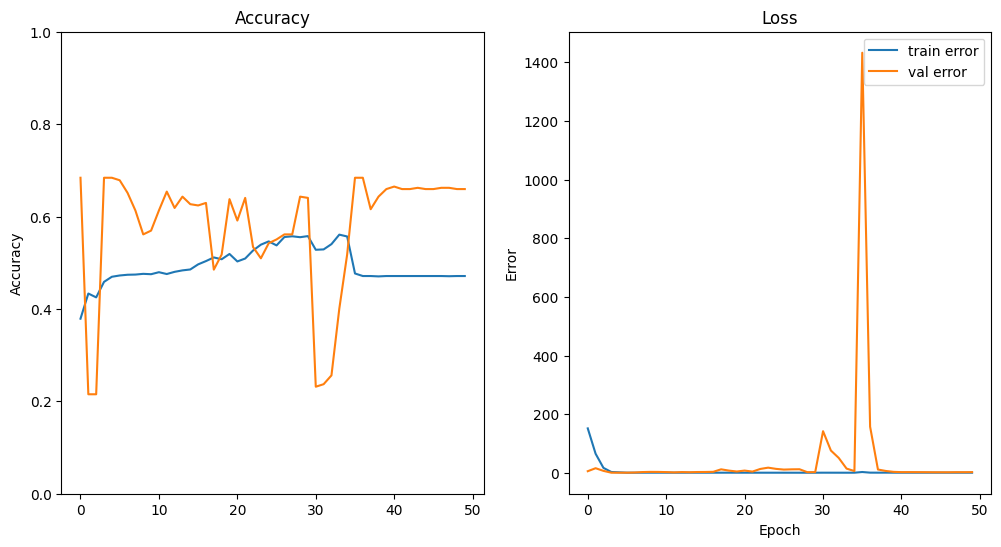

In [18]:
plot_history(hist)

In [19]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)

12/12 - 1s - loss: 0.9352 - accuracy: 0.6658 - 1s/epoch - 90ms/step


In [22]:
# load the weights that yielded the best validation accuracy
model.load_weights(checkpoint_path+'model.weights.best.hdf5')
# evaluate and print test accuracy
score = model.evaluate(X_test, y_test, verbose=0)
print('\n', 'Test accuracy:', score[1])
score # loss and acc


 Test accuracy: 0.66847825050354


[1.0178730487823486, 0.66847825050354]